In [61]:
from matplotlib import pyplot as plt
import numpy as np
import pickle as pkl

import astropy.constants as c
from scipy.integrate import simpson
from scipy.interpolate import interp1d

In [17]:
au = c.au.cgs.value

In [129]:
def lbp(r: float, m_disk: float, r_c: float, gamma: float = 1, r_in: float = 0) -> float:
    """
    Calculate the self-similar Lynden-Bell & Pringle surface density.
    
    Parameters
    ----------
    r: float
        Radius where to evaluate the surface density.
    m_disk: float
        Total disk mass.
    r_c: float
        Tapering radius.
    gamma: float
        Tapering factor

    Returns
    -------

    """
    sigma_0 = (2 - gamma) * m_disk / (2 * np.pi * r_c**2) * np.exp(r_in / r_c)**(2 - gamma)
    
    return sigma_0 * (r / r_c)**(-gamma) * np.exp(-(r / r_c)**(2 - gamma))

def interp_profile(profile_dict: dict, total_disk_mass: float) -> callable:
    """
    Interpolate a profile to use as gas surface density, normalized to a given total disk mass.
    
    Parameters
    ----------
    profile_dict: dict
        Dictionary containing the profile to use as surface density distribution. The keys must be named 'x' and 'y'.
    total_disk_mass: float
        Total disk mass.
        
    Returns
    -------
    float
        Normalized gas surface density function.
    """
    normalization_constant = total_disk_mass / simpson(2 * np.pi * profile_dict['x'] * profile_dict['y'], profile_dict['x'])

    # The profile cannot be <= 0, make sure that doesn't happen.
    y_profile = np.where(profile_dict['y'] > 0, profile_dict['y'], 0)
    # y_profile = np.copy(profile_dict['y'])
    # if np.min(y_profile) <= 0:
    #     y_profile += np.max(y_profile)

    normalization_constant = total_disk_mass / simpson(2 * np.pi * profile_dict['x'] * y_profile, profile_dict['x'])

    interp = interp1d(profile_dict['x'], y_profile, fill_value='extrapolate', kind='quadratic')
    return lambda x: normalization_constant * interp(x)

In [20]:
with open('profile_CO.pickle', 'rb') as f:
    profile_CO = pkl.load(f)

with open('profile_870_micron.pickle', 'rb') as f:
    profile_870mu = pkl.load(f)

### We create a profile by taking the CO profile in the outer disk and the 870 continuum in the inner disk

We do this because there is no mm continuum in the outer disk, so we use the CO

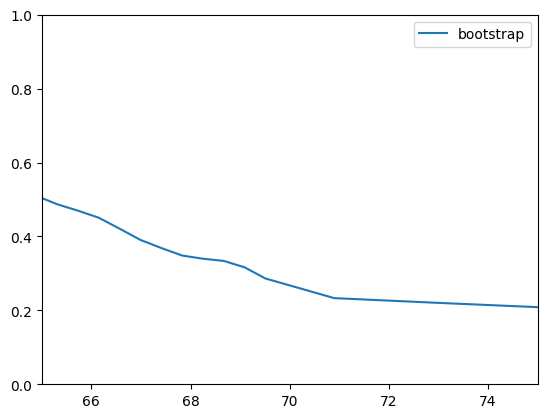

In [110]:
profile_bootstrap = {}

outer_radii_index = np.nonzero(np.asanyarray(profile_CO['x'] > np.max(profile_870mu['x'])))[0]

profile_bootstrap['x'] = np.concatenate((profile_870mu['x'], profile_CO['x'][outer_radii_index]))

norm = profile_870mu['y'][-1] / profile_CO['y'][0]
profile_bootstrap['y'] = np.concatenate((profile_870mu['y'], 12 * norm * profile_CO['y'][outer_radii_index]))
plt.plot(profile_bootstrap['x'] / au, profile_bootstrap['y'], label='bootstrap')
plt.xlim(65, 75)
plt.ylim(0, 1)
plt.legend()

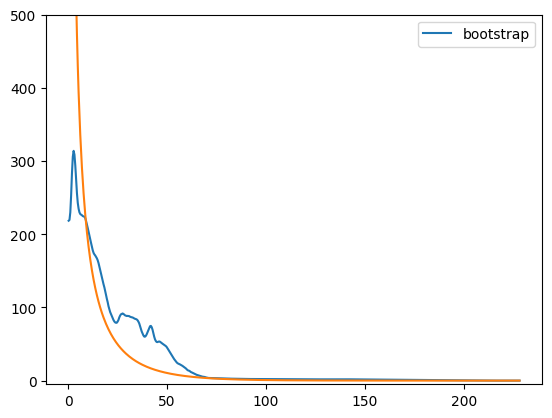

In [139]:
mdisk = 0.11 * c.M_sun.cgs.value

density_func = interp_profile(profile_bootstrap, mdisk)

plt.plot(profile_bootstrap['x'] / au, density_func(profile_bootstrap['x']), label='bootstrap')
plt.plot(profile_bootstrap['x'] / au, lbp(profile_bootstrap['x'], mdisk / 2, 30 * au, 0.9))
plt.ylim(-5, 500)
plt.legend()

In [140]:
with open('profile_bootstrap.pickle', 'wb') as fff:
    pkl.dump(profile_bootstrap, fff)